In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

#Load the data using fast.ai function.

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
import numpy as np

last_skywalker = np.array([0.98, 0.9, -0.9])

For instance, scoring very science-fiction as 0.98, very action as 0.9, and very not old as -0.9. We could represent a user who likes modern sci-fi action movies as:

In [5]:
user1 = np.array([0.9,0.8,-0.6])

We can calculate the match between this combination:

In [6]:
(user1*last_skywalker).sum()

2.1420000000000003

On the other hand for the movie Casablanca we can represent it as:

In [7]:
casablanca = np.array([-0.99,-0.3,0.8])

The match between this combination is:

In [8]:
(user1*casablanca).sum()

-1.611

But we don't have these in data.      
We can learning the latent factors.

In [9]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [10]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We can build a DataLoaders object from the table. By default, it takes the first column of the user, the second column for the item (here our movies), and the third column for the ratings. We need to change the value of item_name in our case to use the titles instead of the IDs:

In [11]:
dls = CollabDataLoaders.from_df(ratings, item_name = 'title', bs = 64)#batchsize
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [12]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
one_hot_3 = one_hot(3, n_users).float()#the third element is 1 anything else is 0.

In [18]:
one_hot_3

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [17]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [19]:
user_factors[3]# it's the same answer as below

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

# Collaborative Filtering from Scratch

In [21]:
class Example:
  def __init__(self, a): self.a = a
  def say(self, x): return f'Hello {self.a}, {x}.'


In [23]:
ee = Example('Dengyi')
ee.say('Good luck')

'Hello Dengyi, Good luck.'

In [32]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, x):
    users = self.user_factors(x[:,0])#first column
    movies = self.movie_factors(x[:,1])#second column
    return(users * movies).sum(dim=1)

In [34]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat()) 

#How does loss decrease? automaticly?
By minimizing the difference between the predicted ratings and the actual ratings using a loss function such as mean squared error (MSE) or binary cross-entropy (BCE), the neural network is able to adjust the weights of the embedding layers during training, in order to improve the accuracy of the predicted ratings. This, in turn, should lead to a decrease in the loss.

In [35]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.366003,1.308087,00:11
1,1.082672,1.075355,00:11
2,0.957155,0.991827,00:10
3,0.846005,0.900593,00:11
4,0.756468,0.884425,00:12


The first thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. For this, we just need to use sigmoid_range, like in <>. One thing we discovered empirically is that it's better to have the range go a little bit over 5, so we use (0, 5.5):

In [36]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [37]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.979315,0.996610,00:10
1,0.871915,0.907024,00:10
2,0.688548,0.876841,00:11
3,0.486655,0.881215,00:10
4,0.371834,0.885472,00:11


In [38]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [39]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.954203,0.943365,00:14
1,0.814953,0.870375,00:13
2,0.631231,0.865736,00:12
3,0.394912,0.887702,00:12
4,0.292698,0.894985,00:11


#Weight Decay, aka L2 regularization

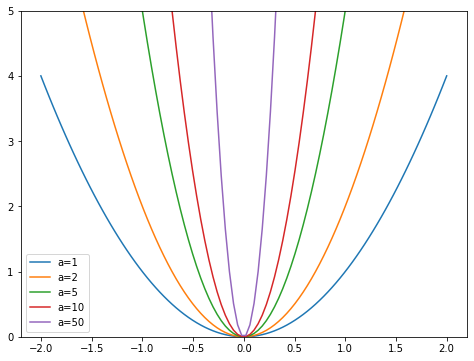

In [40]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [42]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)# try 0.1, 0.01, etc.

epoch,train_loss,valid_loss,time
0,0.921880,0.948146,00:11
1,0.834673,0.883151,00:11
2,0.769019,0.839424,00:11
3,0.622919,0.824238,00:10
4,0.493796,0.825277,00:11


#Create our Own Embedding Module

In [43]:
class T(Module):
  def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [44]:
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [45]:
class T(Module):
  def __init__(self): self.a = nn.Linear(1, 3, bias = False)
    
t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3879],
        [-0.4420],
        [ 0.1152]], requires_grad=True)]

In [46]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [47]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [48]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [49]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.967625,0.949141,00:12
1,0.830253,0.874278,00:12
2,0.742591,0.838686,00:12
3,0.585570,0.827501,00:12
4,0.481969,0.827527,00:12


In [51]:
model.movie_bias.shape

torch.Size([1665])

#Interpreting Embeddings and Biases

In [53]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)',
 'Beautician and the Beast, The (1997)']

In [54]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Star Wars (1977)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

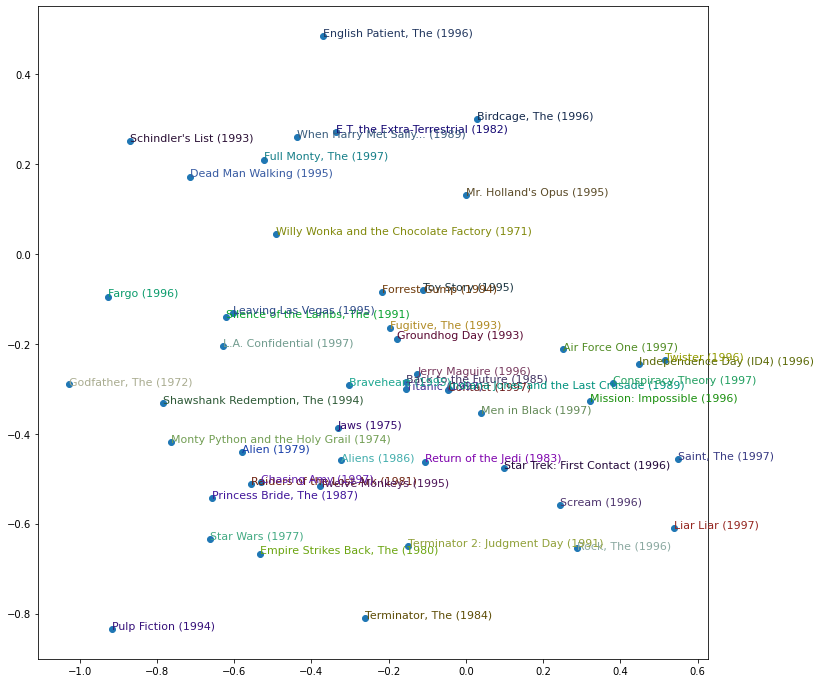

In [55]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()


# Using fastai.collab.     
We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's collab_learner

In [56]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [57]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936918,0.950839,00:14
1,0.851801,0.879753,00:13
2,0.725336,0.836495,00:12
3,0.577120,0.821725,00:12
4,0.491965,0.821030,00:12


In [58]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [59]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)']

# Embedding Distance.  


On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras:  $\sqrt{x^2 + y^2}$
  (assuming that x and y are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to Silence of the Lambs:

In [61]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)'] #o2i : object to id
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Meet John Doe (1941)'

Bootstrapping a Collaborative Filtering Model

#Deep Learning for Vollaborative Filtering

In [62]:
embs = get_emb_sz(dls)
embs #ask fastai which emb we should use: 944 \to 74, 1665 \to 103

[(944, 74), (1665, 102)]

In [63]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [64]:
model = CollabNN(*embs)

In [65]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.925086,0.953710,00:20
1,0.895128,0.902623,00:16
2,0.871660,0.877303,00:17
3,0.801782,0.869722,00:16
4,0.762914,0.872739,00:16


In [66]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.979443,0.982786,00:20
1,0.945375,0.922487,00:18
2,0.846566,0.896732,00:16
3,0.841650,0.874641,00:17
4,0.766083,0.876888,00:16
